In [1]:
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc
#!pip install dvc --ignore-installed
!pip install --upgrade oauth2client
!pip install -r requirements.txt

Requirement already up-to-date: CFEDemands in /home/dan/anaconda3/lib/python3.8/site-packages (0.2.7)
  Using cached ruamel.yaml-0.17.4-py3-none-any.whl (101 kB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)


  Attempting uninstall: ruamel.yaml
    Found existing installation: ruamel-yaml 0.15.87
ERROR: Cannot uninstall 'ruamel-yaml'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
Requirement already up-to-date: oauth2client in /home/dan/anaconda3/lib/python3.8/site-packages (4.1.3)


In [2]:
import pandas as pd

# set dataframes to show float values without exponential
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## (#A) Estimate Demand System

Estimate a system of demands for different kinds of food. Characterize how consumption varies with household need.

Retrieve data from google sheets using private keys:

In [3]:
import pandas as pd
import numpy as np
from eep153_tools import read_sheets

#Nigeria consumption (own production) dataset
Nigeria_Data = '17L5cDhXRLNAckP3JvBLTLSYIguFqP2ebMvQLH96c0n4'

#### Need private keys from json file (we're authenticating using "service accounts")
!gpg --batch --passphrase "noodle octopus" -d ./students-9093fa174318.json.gpg > ./students-9093fa174318.json
####

# Add credentials if sheet not meant to be public
exp_df = read_sheets(Nigeria_Data,sheet='Expenditures',json_creds='./students-9093fa174318.json')
                 
# Change 'ICRISAT' to key of your own sheet in Sheets, above
household_df = read_sheets(Nigeria_Data,sheet="HH Characteristics",json_creds='./students-9093fa174318.json')

# # Assume a single market by setting m = 1 for all
exp_df.insert(loc=2, column='m', value=1)
household_df.insert(loc=2, column='m', value=1)

household_df2 = household_df.copy().set_index(['t', 'j', 'm'])

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


### Data Cleaning and filter data by our chosen population (below poverty line)

In [4]:
exp_df = exp_df.replace(0,np.nan) # Replace zeroes with np.nan

#Convert all value types to float64
for i in range(3, len(exp_df.columns)):
    exp_df.iloc[:, i:] = exp_df.iloc[:, i:].astype('float64')
    
exp_df = exp_df.replace(0.0,np.nan) # Replace zeroes with np.nan

#### Create total expenditure column and filter expenditure dataframe by our condition

We create a new column 'Total expenditure' so we can filter households that have total food spendings under or at poverty line.

In [5]:
household_size_df = pd.DataFrame(household_df2.sum(axis=1))
household_size_df

0
t    j      m   
2010 10001  1  7
     10002  1  7
     10003  1  6
     10004  1  3
     10006  1  3
...           ..
2018 379146 1  4
     379148 1  1
     379151 1  5
     379154 1  2
     379155 1  4

[19249 rows x 1 columns]

In [6]:
exp_df['Total expenditure'] = exp_df.iloc[:, 3:].sum(axis=1)
pd.DataFrame(exp_df['Total expenditure'])

,Total expenditure
0,20225.000
1,15365.000
2,4675.000
3,4465.000
4,7565.000
...,...
19136,31100.000
19137,6410.000
19138,20540.000
19139,22650.000


In [7]:
# Create total expenditure per capita in exp_df
exp_df = exp_df.set_index(['t', 'j', 'm'])
exp_df = pd.concat([exp_df, household_size_df], axis=1)
exp_df.columns = [*exp_df.columns[:-1], 'Household Size']
exp_df['Exp Per Cap'] = exp_df['Total expenditure'] / exp_df['Household Size']
exp_df

(Cocoyam, Spinach, etc)  Agricultural eggs  Animal fat  Apples  \
t    j      m                                                                   
2010 10001  1                      nan            280.000         nan     nan   
     10002  1                      nan            280.000         nan     nan   
     10003  1                      nan            180.000         nan     nan   
     10004  1                      nan            180.000         nan     nan   
     10006  1                      nan                nan         nan     nan   
...                                ...                ...         ...     ...   
2018 379146 1                      nan           1100.000         nan     nan   
     379148 1                  100.000                nan         nan     nan   
     379151 1                      nan            900.000         nan     nan   
     379154 1                  200.000           1200.000         nan     nan   
     379155 1                  100.000            950.000         nan     nan   

               Avocado pear  Baby milk powder  Bananas     Beef  \
t    j      m                                                     
2010 10001  1           nan               nan  200.000  500.000   
     10002  1           nan               nan  180.000 1200.000   
     10003  1           nan               nan  100.000  500.000   
     10004  1           nan               nan  100.000  500.000   
     10006  1           nan               nan  300.000  300.000   
...                     ...               ...      ...      ...   
2018 379146 1           nan               nan      nan      nan   
     379148 1           nan               nan      nan  700.000   
     379151 1           nan               nan  500.000      nan   
     379154 1           nan               nan      nan 1300.000   
     379155 1           nan               nan      nan 1400.000   

               Beer (local and imported)  Biscuits  ...  Tomatoes  Watermelon  \
t    j      m                                       ...                         
2010 10001  1                    540.000       nan  ...   150.000         nan   
     10002  1                   2000.000       nan  ...   120.000         nan   
     10003  1                        nan       nan  ...   100.000         nan   
     10004  1                        nan       nan  ...   100.000         nan   
     10006  1                        nan       nan  ...   400.000         nan   
...                                  ...       ...  ...       ...         ...   
2018 379146 1                        nan       nan  ...       nan     500.000   
     379148 1                        nan       nan  ...   200.000     150.000   
     379151 1                        nan       nan  ...   600.000     600.000   
     379154 1                        nan       nan  ...   100.000     200.000   
     379155 1                        nan       nan  ...   300.000     200.000   

               Wheat flour  White beans  Wild game meat  Yam flour  Yam-roots  \
t    j      m                                                                   
2010 10001  1          nan      600.000             nan        nan   1500.000   
     10002  1          nan      400.000             nan        nan   1200.000   
     10003  1          nan      100.000             nan        nan    400.000   
     10004  1          nan      100.000             nan        nan    400.000   
     10006  1          nan          nan             nan        nan    400.000   
...                    ...          ...             ...        ...        ...   
2018 379146 1          nan          nan             nan        nan   1800.000   
     379148 1          nan          nan             nan        nan   1600.000   
     379151 1      750.000     1600.000             nan        nan   3500.000   
     379154 1          nan          nan             nan        nan    650.000   
     379155 1          nan          nan             nan        

#### Poverty Line Dataframe (Households with food spendings under or equal to poverty line)

In [8]:
#87.8 thousand Naira food spending per year per person
#1688.46 per week
wk_poverty_line = 87800/52

poverty_line_df = exp_df[exp_df['Exp Per Cap'] <= wk_poverty_line]
poverty_line_df

(Cocoyam, Spinach, etc)  Agricultural eggs  Animal fat  Apples  \
t    j      m                                                                   
2010 10003  1                      nan            180.000         nan     nan   
     10004  1                      nan            180.000         nan     nan   
     10008  1                      nan            360.000         nan     nan   
     10009  1                      nan                nan         nan     nan   
     10011  1                      nan                nan         nan     nan   
...                                ...                ...         ...     ...   
2018 379103 1                      nan           1000.000         nan     nan   
     379105 1                      nan            600.000         nan     nan   
     379123 1                      nan             80.000         nan     nan   
     379127 1                      nan                nan         nan     nan   
     379143 1                  150.000            200.000         nan     nan   

               Avocado pear  Baby milk powder  Bananas     Beef  \
t    j      m                                                     
2010 10003  1           nan               nan  100.000  500.000   
     10004  1           nan               nan  100.000  500.000   
     10008  1        90.000               nan  300.000      nan   
     10009  1           nan           600.000  100.000  300.000   
     10011  1           nan               nan      nan  500.000   
...                     ...               ...      ...      ...   
2018 379103 1           nan               nan      nan      nan   
     379105 1           nan               nan      nan      nan   
     379123 1           nan               nan      nan 1300.000   
     379127 1           nan               nan  150.000      nan   
     379143 1           nan               nan      nan      nan   

               Beer (local and imported)  Biscuits  ...  Tomatoes  Watermelon  \
t    j      m                                       ...                         
2010 10003  1                        nan       nan  ...   100.000         nan   
     10004  1                        nan       nan  ...   100.000         nan   
     10008  1                        nan       nan  ...   100.000         nan   
     10009  1                        nan       nan  ...   200.000         nan   
     10011  1                        nan       nan  ...   100.000         nan   
...                                  ...       ...  ...       ...         ...   
2018 379103 1                        nan       nan  ...       nan         nan   
     379105 1                        nan       nan  ...   100.000     300.000   
     379123 1                        nan       nan  ...       nan         nan   
     379127 1                        nan       nan  ...       nan     200.000   
     379143 1                        nan       nan  ...       nan     320.000   

               Wheat flour  White beans  Wild game meat  Yam flour  Yam-roots  \
t    j      m                                                                   
2010 10003  1          nan      100.000             nan        nan    400.000   
     10004  1          nan      100.000             nan        nan    400.000   
     10008  1          nan      400.000             nan        nan    400.000   
     10009  1          nan      270.000             nan        nan    400.000   
     10011  1          nan      200.000             nan        nan    400.000   
...                    ...          ...             ...        ...        ...   
2018 379103 1          nan          nan             nan        nan   1400.000   
     379105 1          nan          nan             nan        nan        nan   
     379123 1          nan      400.000             nan        nan        nan   
     379127 1          nan          nan             nan        nan        nan   
     379143 1          nan      800.000             nan        

In [9]:
#remove total expenditure column from calculation
poverty_line_df = poverty_line_df.drop(columns=['Total expenditure', 'Household Size', 'Exp Per Cap']) 

# poverty_line_df.set_index(['j', 't', 'm'])
poverty_line_df

(Cocoyam, Spinach, etc)  Agricultural eggs  Animal fat  Apples  \
t    j      m                                                                   
2010 10003  1                      nan            180.000         nan     nan   
     10004  1                      nan            180.000         nan     nan   
     10008  1                      nan            360.000         nan     nan   
     10009  1                      nan                nan         nan     nan   
     10011  1                      nan                nan         nan     nan   
...                                ...                ...         ...     ...   
2018 379103 1                      nan           1000.000         nan     nan   
     379105 1                      nan            600.000         nan     nan   
     379123 1                      nan             80.000         nan     nan   
     379127 1                      nan                nan         nan     nan   
     379143 1                  150.000            200.000         nan     nan   

               Avocado pear  Baby milk powder  Bananas     Beef  \
t    j      m                                                     
2010 10003  1           nan               nan  100.000  500.000   
     10004  1           nan               nan  100.000  500.000   
     10008  1        90.000               nan  300.000      nan   
     10009  1           nan           600.000  100.000  300.000   
     10011  1           nan               nan      nan  500.000   
...                     ...               ...      ...      ...   
2018 379103 1           nan               nan      nan      nan   
     379105 1           nan               nan      nan      nan   
     379123 1           nan               nan      nan 1300.000   
     379127 1           nan               nan  150.000      nan   
     379143 1           nan               nan      nan      nan   

               Beer (local and imported)  Biscuits  ...  Sweet Potatoes  \
t    j      m                                       ...                   
2010 10003  1                        nan       nan  ...         200.000   
     10004  1                        nan       nan  ...             nan   
     10008  1                        nan       nan  ...             nan   
     10009  1                        nan       nan  ...             nan   
     10011  1                        nan       nan  ...             nan   
...                                  ...       ...  ...             ...   
2018 379103 1                        nan       nan  ...         300.000   
     379105 1                        nan       nan  ...             nan   
     379123 1                        nan       nan  ...         100.000   
     379127 1                        nan       nan  ...             nan   
     379143 1                        nan       nan  ...             nan   

                 Tea  Tomato puree(canned)  Tomatoes  Watermelon  Wheat flour  \
t    j      m                                                                   
2010 10003  1 60.000                90.000   100.000         nan          nan   
     10004  1 30.000                60.000   100.000         nan          nan   
     10008  1    nan               350.000   100.000         nan          nan   
     10009  1 60.000               120.000   200.000         nan          nan   
     10011  1    nan                60.000   100.000         nan          nan   
...              ...                   ...       ...         ...          ...   
2018 379103 1    nan               600.000       nan         nan          nan   
     379105 1    nan                   nan   100.000     300.000          nan   
     379123 1    nan                   nan       nan         nan          nan   
     379127 1    nan               350.000       nan     200.000          nan   
     379143 1    nan                   nan       nan     320.000          nan   

               White beans  Wild game meat  Yam flour  Yam-

#### Filter household_df_p to include those only at or below poverty_line:

In [10]:
# filter households to those only at or below poverty line
household_df_p = household_df.set_index(['t', 'j', 'm'])
idx_selected_households = poverty_line_df.index.tolist()
household_df_p = household_df_p[household_df_p.index.isin(idx_selected_households)]
household_df_p

M 0-3  M 4-8  M 9-13  M 14-18  M 19-30  M 31-50  M 51+  F 0-3  \
t    j      m                                                                  
2010 10003  1      0      1       1        1        0        0      1      0   
     10004  1      0      0       1        0        0        0      1      0   
     10008  1      0      0       1        0        0        0      1      0   
     10009  1      0      0       0        0        0        1      0      1   
     10011  1      0      0       0        2        1        0      0      0   
...              ...    ...     ...      ...      ...      ...    ...    ...   
2018 379103 1      1      0       0        0        1        0      1      0   
     379105 1      0      0       0        0        0        0      0      0   
     379123 1      0      0       0        0        1        0      0      0   
     379127 1      1      0       0        0        0        1      0      0   
     379143 1      0      0       0        0        2        1      0      0   

               F 4-8  F 9-13  F 14-18  F 19-30  F 31-50  F 51+  
t    j      m                                                   
2010 10003  1      0       1        0        0        1      0  
     10004  1      0       0        0        0        0      1  
     10008  1      1       2        1        0        1      0  
     10009  1      0       0        1        1        0      0  
     10011  1      0       1        0        1        1      0  
...              ...     ...      ...      ...      ...    ...  
2018 379103 1      0       0        0        1        0      1  
     379105 1      0       0        0        1        1      1  
     379123 1      0       0        0        0        1      0  
     379127 1      0       1        0        1        0      0  
     379143 1      0       0        0        2        0      0  

[15790 rows x 14 columns]

#### Logged Food Expenditure Dataframe (after running np.log on values)

In [11]:
# replace 0 with nan
poverty_line_df = poverty_line_df.replace(0,np.nan) 

# Take logs of expenditures of our selected population and name it log_poverty_line_df
log_poverty_line_df = np.log(poverty_line_df)
log_poverty_line_df

(Cocoyam, Spinach, etc)  Agricultural eggs  Animal fat  Apples  \
t    j      m                                                                   
2010 10003  1                      nan              5.193         nan     nan   
     10004  1                      nan              5.193         nan     nan   
     10008  1                      nan              5.886         nan     nan   
     10009  1                      nan                nan         nan     nan   
     10011  1                      nan                nan         nan     nan   
...                                ...                ...         ...     ...   
2018 379103 1                      nan              6.908         nan     nan   
     379105 1                      nan              6.397         nan     nan   
     379123 1                      nan              4.382         nan     nan   
     379127 1                      nan                nan         nan     nan   
     379143 1                    5.011              5.298         nan     nan   

               Avocado pear  Baby milk powder  Bananas  Beef  \
t    j      m                                                  
2010 10003  1           nan               nan    4.605 6.215   
     10004  1           nan               nan    4.605 6.215   
     10008  1         4.500               nan    5.704   nan   
     10009  1           nan             6.397    4.605 5.704   
     10011  1           nan               nan      nan 6.215   
...                     ...               ...      ...   ...   
2018 379103 1           nan               nan      nan   nan   
     379105 1           nan               nan      nan   nan   
     379123 1           nan               nan      nan 7.170   
     379127 1           nan               nan    5.011   nan   
     379143 1           nan               nan      nan   nan   

               Beer (local and imported)  Biscuits  ...  Sweet Potatoes   Tea  \
t    j      m                                       ...                         
2010 10003  1                        nan       nan  ...           5.298 4.094   
     10004  1                        nan       nan  ...             nan 3.401   
     10008  1                        nan       nan  ...             nan   nan   
     10009  1                        nan       nan  ...             nan 4.094   
     10011  1                        nan       nan  ...             nan   nan   
...                                  ...       ...  ...             ...   ...   
2018 379103 1                        nan       nan  ...           5.704   nan   
     379105 1                        nan       nan  ...             nan   nan   
     379123 1                        nan       nan  ...           4.605   nan   
     379127 1                        nan       nan  ...             nan   nan   
     379143 1                        nan       nan  ...             nan   nan   

               Tomato puree(canned)  Tomatoes  Watermelon  Wheat flour  \
t    j      m                                                            
2010 10003  1                 4.500     4.605         nan          nan   
     10004  1                 4.094     4.605         nan          nan   
     10008  1                 5.858     4.605         nan          nan   
     10009  1                 4.787     5.298         nan          nan   
     10011  1                 4.094     4.605         nan          nan   
...                             ...       ...         ...          ...   
2018 379103 1                 6.397       nan         nan          nan   
     379105 1                   nan     4.605       5.704          nan   
     379123 1                   nan       nan         nan          nan   
     379127 1                 5.858       nan       5.298          nan   
     379143 1                   nan       nan       5.768          nan   

               White beans  Wild game meat  Yam flour  Yam-roots  
t    j      m                               

#### Add 'log Hsize' column to household_df:

In [12]:
# set index to j, t, m so that df.sum() ignore index values
household_df_p = household_df_p.reset_index()
household_df_p.set_index(['j','t','m'], inplace=True)

# create new column of household size
household_df_p['Hsize'] = household_df_p.sum(axis=1).values

# remove erroneous data with household_size = 0
household_df_p = household_df_p[household_df_p['Hsize'] > 0]

# create new column 'log Hsize'
household_df_p['log Hsize'] = np.log(household_df_p['Hsize'])

# remove Hsize column
household_df_p = household_df_p.drop(columns=['Hsize']) 

#### Household Characteristic Table (Only includes households at/below poverty line)

In [13]:
household_df_p

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,log Hsize
j,t,m,,,,,,,,,,,,,,,
10003,2010,1,0,1,1,1,0,0,1,0,0,1,0,0,1,0,1.792
10004,2010,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1.099
10008,2010,1,0,0,1,0,0,0,1,0,1,2,1,0,1,0,1.946
10009,2010,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1.386
10011,2010,1,0,0,0,2,1,0,0,0,0,1,0,1,1,0,1.792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379103,2018,1,1,0,0,0,1,0,1,0,0,0,0,1,0,1,1.609
379105,2018,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1.099
379123,2018,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0.693


### Estimation



With nothing more than this, we can estimate the demand system.  This
happens in two steps.  The first is the &ldquo;reduced form&rdquo; step:



In [14]:
import cfe

#regressand y is food expenditures (np.logged) by our selected population
#regressor z is household demographics

result = cfe.Result(y=log_poverty_line_df,z=household_df_p, min_xproducts=15)

This creates a complicated &ldquo;Result&rdquo; object, with lots of different
attributes.  Note from below that attributes $y$ and $z$ are now defined.



In [15]:
result

<xarray.Result>
Dimensions:           (i: 43, j: 7158, k: 15, m: 1, t: 4)
Coordinates:
  * j                 (j) int64 10001 10002 10003 10004 ... 379123 379127 379143
  * m                 (m) int64 1
  * t                 (t) int64 2010 2012 2015 2018
  * i                 (i) <U36 '(Cocoyam, Spinach, etc)' ... 'Yam-roots'
  * k                 (k) <U9 'M 0-3' 'M 4-8' 'M 9-13' ... 'F 51+' 'log Hsize'
Data variables: (12/20)
    alpha             object None
    beta              object None
    delta             object None
    prices            object None
    characteristics   (k, j, t, m) float64 nan 1.0 1.0 nan ... nan nan nan 1.609
    loglambdas        object None
    ...                ...
    se_beta           object None
    se_alpha          object None
    se_a              object None
    y                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan 7.003
    logp              object None
    z                 (k, j, t, m) float64 nan 1.0 1.0 nan ... nan nan nan 1.609
Attributes:
    firstround:            2010
    min_proportion_items:  0.125
    min_xproducts:         15
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    verbose:               False

In [16]:
# result.get_loglambdas(as_df=True).quantile(0.8)

### First step of Estimation



Recall that there are two steps to estimation; the first step
involves estimating the &ldquo;reduced form&rdquo; linear regression 
$$
y_{it}^j = {a}_{it} + \delta_i'{z}^j_t + \epsilon_{it}^j.
$$

The Result class has code to estimate this in one line:



In [17]:
result.get_reduced_form()

After running this we can examine the estimated coefficients $\delta$:



In [18]:
result.delta.to_dataframe().unstack('k')

delta                                \
k                                     M 0-3  M 4-8 M 9-13 M 14-18 M 19-30   
i                                                                           
(Cocoyam, Spinach, etc)              -0.087  0.013 -0.037  -0.070   0.019   
Agricultural eggs                    -0.044  0.006 -0.003  -0.019   0.068   
Bananas                               0.055 -0.009  0.064   0.038   0.035   
Beef                                  0.002  0.007 -0.004   0.037   0.037   
Beer (local and imported)            -0.074  0.027 -0.022  -0.037  -0.027   
Bread                                -0.057  0.011 -0.014  -0.012   0.018   
Brown beans                           0.048  0.029  0.051   0.036   0.030   
Chicken                              -0.075  0.078 -0.024   0.018   0.059   
Chocolate drinks                      0.011 -0.086 -0.054  -0.105  -0.029   
Cocoyam                              -0.114 -0.126 -0.074  -0.042  -0.024   
Condiments,(salt,spices,pepper, etc) -0.006  0.056  0.025   0.043   0.099   
Fish-Dried                           -0.024 -0.061  0.008  -0.014   0.009   
Fish-Fresh                           -0.063 -0.066 -0.061   0.016   0.025   
Fish-Frozen                          -0.066 -0.031 -0.015   0.004   0.006   
Fish-Smoked                           0.044  0.055 -0.007   0.034   0.014   
Garden eggs/egg plant                 0.020  0.057  0.068   0.004   0.026   
Gari -Yellow                         -0.044  0.006 -0.036  -0.051   0.005   
Gari-White                           -0.019 -0.018 -0.026  -0.017  -0.017   
Goat                                  0.018 -0.062  0.018  -0.011   0.042   
Groundnut oil                         0.026  0.012  0.020   0.008   0.019   
Maize flour                           0.009 -0.021  0.036   0.083   0.008   
Malt drinks                          -0.015  0.012 -0.014   0.007  -0.019   
Milk powder                           0.030 -0.064 -0.006  -0.034  -0.011   
Milk tinned (unsweetened)             0.027 -0.004 -0.027  -0.066  -0.019   
Okra-dried                            0.008  0.022  0.061   0.061  -0.004   
Okra-fresh                            0.009  0.034  0.011   0.020   0.041   
Onions                                0.022  0.053  0.036   0.042   0.052   
Orange/tangerine                      0.057  0.057  0.065   0.058   0.073   
Other vegetables (fresh or canned)   -0.021 -0.011 -0.046   0.031   0.042   
Palm oil                             -0.003  0.030  0.024   0.010   0.020   
Pineapples                            0.095  0.023  0.092   0.028   0.028   
Plantains                             0.087 -0.017  0.051   0.047   0.011   
Rice-Imported                         0.051  0.125  0.058   0.090   0.087   
Rice-local                            0.039  0.068  0.074   0.057   0.031   
Sachet water                         -0.108 -0.050 -0.090  -0.030  -0.004   
Soft drinks (Coca cola, spirit etc)  -0.004  0.011 -0.010  -0.021   0.044   
Sugar                                 0.057  0.106  0.088   0.035   0.095   
Sweet Potatoes                        0.055  0.049  0.080   0.032   0.069   
Tea                                   0.066 -0.144  0.006   0.071  -0.124   
Tomato puree(canned)                 -0.013  0.014 -0.006  -0.033  -0.032   
Tomatoes                             -0.009  0.011  0.005   0.014   0.018   
White beans                          -0.005  0.026  0.012  -0.006  -0.000   
Yam-roots                             0.014 -0.008  0.060   0.039   0.007   

                                                                          \
k                                    M 31-50  M 51+  F 0-3  F 4-8 F 9-13   
i                                                                          
(Cocoyam, Spinach, etc)               -0.058  0.010 -0.039 -0.046 -0.033   
Agricultural eggs                      0.020 -0.016  0.003 -0.014 -0.053   
Bananas                                0.025  0.028  0.039 -0.014  0.005   
Beef                                   

Also the good-time constants $a_{it}$ (this captures the effects of prices)<br>
i.e. differences in year and alpha coefficient


In [19]:
result.a.to_dataframe().unstack('i')

a                                  \
i      (Cocoyam, Spinach, etc) Agricultural eggs Bananas  Beef   
t    m                                                           
2010 1                   3.650             4.373   4.370 5.561   
2012 1                   3.467             4.173   4.433 5.570   
2015 1                   4.052             4.076   4.474 5.766   
2018 1                   4.024             4.384   4.640 5.876   

                                                                             \
i      Beer (local and imported) Bread Brown beans Chicken Chocolate drinks   
t    m                                                                        
2010 1                     5.140 4.568       4.676   5.605            4.322   
2012 1                     5.297 4.511       4.968   6.083            3.930   
2015 1                     5.248 4.859       5.005   6.049            3.919   
2018 1                     5.156 4.789       5.157   6.402            3.825   

                ...                          \
i      Cocoyam  ... Rice-local Sachet water   
t    m          ...                           
2010 1   4.191  ...      4.528        3.423   
2012 1   4.348  ...      4.748        3.499   
2015 1   4.081  ...      5.130        4.024   
2018 1   4.531  ...      5.125        3.921   

                                                                       \
i      Soft drinks (Coca cola, spirit etc) Sugar Sweet Potatoes   Tea   
t    m                                                                  
2010 1                               4.205 3.274          4.804 3.956   
2012 1                               4.299 2.991          4.465 3.750   
2015 1                               4.520 3.084          4.906 3.914   
2018 1                               4.746 3.093          4.864 3.864   

                                                            
i      Tomato puree(canned) Tomatoes White beans Yam-roots  
t    m                                                      
2010 1                3.605    4.134       4.370     5.056  
2012 1                3.861    4.157       4.714     5.178  
2015 1                4.137    4.284       4.811     5.335  
2018 1                4.204    4.388       5.017     5.498  

[4 rows x 43 columns]

### Second step of Estimation



The second step involves using Singular Value Decomposition to find
the rank one matrix that best approximates the residuals $e_{it}^j$.
This can be interpreted as
$$
    -\beta_i\log\lambda^j_t,
$$
where the $\log\lambda^j_t$ is the log of the marginal utility of
expenditures (MUE) for household $j$ at time $t$, and where $\beta_i$ are
the corresponding &ldquo;Frisch elasticities&rdquo; that tell us how much
demand changes as the MUE falls.

Estimates can also be computed as a one-liner:



In [20]:
result.get_beta(as_df=True)

i
(Cocoyam, Spinach, etc)                0.293
Agricultural eggs                      0.316
Bananas                                0.306
Beef                                   0.273
Beer (local and imported)              0.280
Bread                                  0.313
Brown beans                            0.215
Chicken                                0.203
Chocolate drinks                       0.502
Cocoyam                                0.215
Condiments,(salt,spices,pepper, etc)   0.321
Fish-Dried                             0.253
Fish-Fresh                             0.231
Fish-Frozen                            0.155
Fish-Smoked                            0.324
Garden eggs/egg plant                  0.152
Gari -Yellow                           0.192
Gari-White                             0.266
Goat                                   0.112
Groundnut oil                          0.240
Maize flour                            0.339
Malt drinks                            0.211
Milk pow

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.  (This can be controlled using the
`min_proportion_items` and `min_xproducts` attributes when one
instantiates the result object.)



### Assessment of Fit



Now, let&rsquo;s see how we did, by comparing total expenditures predicted by the
model we&rsquo;ve estimated with actual total expenditures:



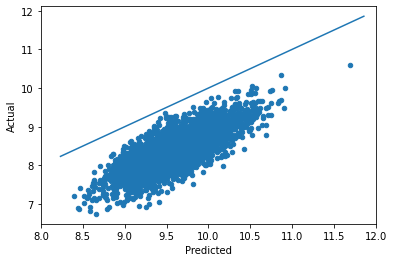

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.xlim((6, 12))
plt.xlim((8, 12))
plt.plot([vmin,vmax],[vmin,vmax])

## (B) Nutritional content of different foods

For all the foods you're considering you'll need to be able to describe their nutritional content, in terms that allow you to compare with recommended daily allowances.

#### Load in Nigeria Consumption dataframe:

In [22]:
import pandas as pd
import numpy as np
from eep153_tools import read_sheets

url = '1kG_fVBmj9EEF9LOwxN30HBxkQENOoWeQjVPYzMJe3b4'

#### Need private keys from json file (we're authenticating using "service accounts")
!gpg --batch --passphrase "noodle octopus" -d ./students-9093fa174318.json.gpg > ./students-9093fa174318.json
####

# Add credentials if sheet not meant to be public
consumption_df = read_sheets(key=url ,sheet='Consumption',json_creds='./students-9093fa174318.json')

consumption_df.insert(loc=2, column='m', value=1)
consumption_df = consumption_df.set_index(['t', 'j', 'm'])

# remove erraneous column 'Canned'
consumption_df = consumption_df.drop(columns=['Canned'])

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


In [23]:
consumption_df.index

MultiIndex([(2010,  10001, 1),
            (2010,  10001, 1),
            (2010,  10002, 1),
            (2010,  10002, 1),
            (2010,  10003, 1),
            (2010,  10003, 1),
            (2010,  10004, 1),
            (2010,  10004, 1),
            (2010,  10006, 1),
            (2010,  10006, 1),
            ...
            (2018, 379141, 1),
            (2018, 379143, 1),
            (2018, 379144, 1),
            (2018, 379146, 1),
            (2018, 379146, 1),
            (2018, 379148, 1),
            (2018, 379151, 1),
            (2018, 379151, 1),
            (2018, 379154, 1),
            (2018, 379155, 1)],
           names=['t', 'j', 'm'], length=39172)

In [24]:
len(set(consumption_df.index))

17023

In [25]:
household_df.index

RangeIndex(start=0, stop=19249, step=1)

In [26]:
len(set(household_df.index))

19249

In [27]:
# Filter household_dfs by households with consumption data
household_df = household_df[household_df.index.isin(consumption_df.index)]

In [28]:
len(set(household_df.index))

0

In [29]:
poor_household_ids = poverty_line_df.index
poor_household_ids

MultiIndex([(2010,  10003, 1),
            (2010,  10004, 1),
            (2010,  10008, 1),
            (2010,  10009, 1),
            (2010,  10011, 1),
            (2010,  10012, 1),
            (2010,  10013, 1),
            (2010,  10014, 1),
            (2010,  10015, 1),
            (2010,  10016, 1),
            ...
            (2018, 379091, 1),
            (2018, 379092, 1),
            (2018, 379093, 1),
            (2018, 379094, 1),
            (2018, 379096, 1),
            (2018, 379103, 1),
            (2018, 379105, 1),
            (2018, 379123, 1),
            (2018, 379127, 1),
            (2018, 379143, 1)],
           names=['t', 'j', 'm'], length=15790)

In [30]:
consumption_df_p = consumption_df[consumption_df.index.isin(poor_household_ids)]
consumption_df_p

u  (Cocoyam, Spinach, etc)  Agricultural eggs  \
t    j      m                                                                  
2010 10003  1          Kilograms                      nan              0.440   
            1             Litres                      nan                nan   
     10004  1          Kilograms                      nan              0.440   
            1             Litres                      nan                nan   
     10008  1          Kilograms                      nan              0.890   
...                          ...                      ...                ...   
2018 379089 1  1. KILOGRAMS (KG)                      nan                nan   
     379090 1  1. KILOGRAMS (KG)                      nan                nan   
     379093 1  1. KILOGRAMS (KG)                      nan                nan   
     379123 1  1. KILOGRAMS (KG)                      nan                nan   
     379143 1  1. KILOGRAMS (KG)                      nan                nan   

               Animal fat  Apples  Avocado pear  Baby milk powder  Bananas  \
t    j      m                                                                
2010 10003  1         nan     nan           nan               nan    0.350   
            1         nan     nan           nan               nan      nan   
     10004  1         nan     nan           nan               nan    0.350   
            1         nan     nan           nan               nan      nan   
     10008  1         nan     nan         0.900               nan    1.550   
...                   ...     ...           ...               ...      ...   
2018 379089 1         nan     nan           nan               nan      nan   
     379090 1         nan     nan           nan               nan      nan   
     379093 1         nan     nan           nan               nan      nan   
     379123 1         nan     nan           nan               nan      nan   
     379143 1         nan     nan           nan               nan      nan   

               Beef  Beer (local and imported)  ...  Sweet Potatoes   Tea  \
t    j      m                                   ...                         
2010 10003  1 0.300                        nan  ...           1.400 0.300   
            1   nan                        nan  ...             nan   nan   
     10004  1 0.300                        nan  ...             nan 0.150   
            1   nan                        nan  ...             nan   nan   
     10008  1   nan                        nan  ...             nan   nan   
...             ...                        ...  ...             ...   ...   
2018 379089 1 1.500                        nan  ...             nan   nan   
     379090 1 0.500                        nan  ...             nan   nan   
     379093 1 0.500                        nan  ...             nan   nan   
     379123 1 1.000                        nan  ...             nan   nan   
     379143 1   nan                        nan  ...             nan   nan   

               Tomato puree(canned)  Tomatoes  Watermelon  Wheat flour  \
t    j      m                                                            
2010 10003  1                 0.210     1.000         nan          nan   
            1                   nan       nan         nan          nan   
     10004  1                 0.140     1.000         nan          nan   
            1                   nan       nan         nan          nan   
     10008  1                 3.500     1.000         nan          nan   
...                             ...       ...         ...          ...   
2018 379089 1                   nan       nan         nan          nan   
     379090 1                   nan       nan         nan          nan   
     379093 1                   nan       nan         nan          nan   
     379123 1                   nan       nan         nan          nan   
     379143 1                   nan       nan         nan          nan   

          

#### Loading in fdc_codes from google sheets:

In [31]:
# File with private keys for relevant service account to authenticate
# and access google spreadsheets
!gpg --batch --passphrase "casimir" -d project3-key.json.gpg > project3-key.json

serviceacct = {'project2-casimir-funk':'project3-key.json'}
sheet_url = "https://docs.google.com/spreadsheets/d/1O0nHroRtnzBKSZXVWlqdTLIX16n5gg8aVBPcTjvLFKo/edit#gid=0"
sheet_name = 'Codes'

# Add credentials if sheet not meant to be public
fdc_code_df = read_sheets(key=sheet_url, json_creds=serviceacct["project2-casimir-funk"], sheet=sheet_name)
fdc_code_df

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


,Food description,USDA FDC ID,Kilograms/Litres
0,Pawpaw,1687869,0.100
1,Sheabutter,474641,0.100
2,Watermelon,1620656,0.100
3,Biscuits,477478,0.100
4,Buns/PofPof/Donuts,444979,0.100
...,...,...,...
127,Beer (local and imported),1104393,0.100
128,Palm wine,173185,0.100
129,Pito,1104393,0.100
130,Gin,1104487,0.100


In [32]:
#list of foods consumed:
fdc_food_items = fdc_code_df['Food description'].tolist()
fdc_food_items

['Pawpaw',
 'Sheabutter',
 'Watermelon',
 'Biscuits',
 'Buns/PofPof/Donuts',
 'Cake',
 'Cashew nut',
 'Cassava-Roots',
 'Cheese (wara)',
 'Ogbonno grinded',
 'Ogbonno ungrinded',
 'Meat pie/Sausage roll',
 'Guava',
 'Kola nut',
 'Coconut',
 'Coconut oil',
 'Dry pepper',
 'Fruit juice canned',
 'Grinded pepper',
 'Apples',
 'Groundnuts (shelled)',
 'Groundnuts (unshelled)',
 'Fresh pepper',
 'Maize (off the cob/grains)',
 'Maize (on the cob)',
 'Maize (shelled/off the cob)',
 'Maize (shelled/on the cob)',
 'Maize (unshelled/on the cob)',
 'Maize shelled',
 'Melon (ground)',
 'Chocolate drinks',
 'Guinea Corn/Sorghum',
 'Millet',
 'Maize',
 'Rice-local',
 'Rice-Imported',
 'Bread',
 'Maize flour',
 'Yam flour',
 'Cassava flour',
 'Wheat flour',
 'Other grains and flour',
 'Cassava-roots',
 'Yam-roots',
 'Gari-White',
 'Gari -Yellow',
 'Cocoyam',
 'Plantains',
 'Sweet Potatoes',
 'Potatoes',
 'Other roots and tuber',
 'Soya beans',
 'Brown beans',
 'White beans',
 'Groundnuts',
 'Other nu

In [33]:
#example: accessing fdc code from the dataframe
f = fdc_food_items[29]
fdc_id = int(fdc_code_df[fdc_code_df['Food description'] == f]['USDA FDC ID'].values[0])
fdc_id

746770

### Nutritional Data of all foods consumed by our households:

In [34]:
import fooddatacentral as fdc

dri_df = pd.read_csv('./diet_minimums.csv').set_index('Nutrition').iloc[:,2:]

# API key for FDC
apikey = "V0mOAdVrSineT4d2VTMTJUNPAsBTnjzUAU6e6H6V" # inIyO1begWSRqsYtxS7m6p09PSyq7Qiw7fxzV2qN"


# Query to fdc and get dataframe containing nutritional data of foods using their fdc_ids
food_to_nutrients = {}
for f in fdc_food_items:
    fdc_id = fdc_code_df[fdc_code_df['Food description'] == f]['USDA FDC ID'].values[0]
    if not np.isnan(fdc_id):
        try:
            fdc_id = int(fdc_id)
            food_to_nutrients[f] = fdc.nutrients(apikey, fdc_id).Quantity
        except AttributeError:
            print(fdc_id)
            pass
#             warnings.warn("Couldn't find FDC Code %s for food %s." % (f, fdc_id))

nutritional_df = pd.DataFrame(food_to_nutrients,dtype=float).fillna(0.0)
nutritional_df = nutritional_df[nutritional_df.index.isin(dri_df.index)]
nutritional_df

,Pawpaw,Sheabutter,Watermelon,Biscuits,Buns/PofPof/Donuts,Cake,Cashew nut,Cassava-Roots,Cheese (wara),Ogbonno grinded,...,Malt drinks,"Soft drinks (Coca cola, spirit etc)",Fruit juice canned/Pack,Other Non-acoholic drinks,Other non-acoholic drinks,Beer (local and imported),Palm wine,Pito,Gin,Other alcoholic beverages
"Calcium, Ca",150.000,0.000,0.000,400.000,85.000,36.000,0.000,16.000,714.000,11.000,...,8.000,1.000,7.000,0.000,0.000,4.000,8.000,4.000,0.000,0.000
"Carbohydrate, by difference",65.000,0.000,7.450,33.330,53.520,66.360,67.440,38.060,3.570,14.980,...,0.270,10.360,12.410,10.670,10.670,3.550,2.720,3.550,0.000,0.000
Energy,250.000,867.000,31.000,347.000,324.000,427.000,488.000,667.000,393.000,60.000,...,58.000,42.000,48.000,45.000,45.000,43.000,347.000,43.000,231.000,967.000
"Fiber, total dietary",10.000,0.000,0.400,1.300,1.400,2.700,2.300,1.800,0.000,1.600,...,0.000,0.000,0.900,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"Folate, DFE",0.000,0.000,0.000,0.000,0.000,0.000,0.000,27.000,0.000,43.000,...,18.000,0.000,3.000,0.000,0.000,6.000,1.000,6.000,0.000,0.000
"Iron, Fe",0.000,0.000,0.000,2.400,1.520,3.270,1.670,0.270,0.000,0.160,...,0.030,0.020,0.330,0.000,0.000,0.020,0.370,0.020,0.040,0.010
"Magnesium, Mg",0.000,0.000,0.000,0.000,0.000,0.000,0.000,21.000,0.000,10.000,...,12.000,0.000,8.000,0.000,0.000,6.000,11.000,6.000,0.000,0.000
Niacin,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.854,0.000,0.669,...,1.100,0.000,0.336,0.000,0.000,0.513,0.166,0.513,0.013,0.000
"Phosphorus, P",0.000,0.000,0.000,0.000,0.000,0.000,0.000,27.000,0.000,14.000,...,32.000,9.000,13.000,0.000,0.000,14.000,20.000,14.000,4.000,5.000
"Potassium, K",0.000,0.000,0.000,0.000,0.000,0.000,0.000,271.000,0.000,168.000,...,62.000,5.000,136.000,0.000,0.000,27.000,99.000,27.000,2.000,1.000


## (B) Nutritional adequacy of diet

Given the food actually consumed in your data, what can you say about the adequacy of the diets in the population you're studying? What proportion of households consume enough so that members will exceed dietary recommendations? What proportion do not?

#### Dietary Reference Intakes Dataframe:

In [35]:
dri_df

,C 1-3,F 4-8,M 4-8,F 9-13,M 9-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
Nutrition,,,,,,,,,,,,,
Energy,1000.000,1200.000,1400.000,1600.000,1800.000,1800.000,2200.000,2000.000,2400.000,1800.000,2200.000,1600.000,2000.000
Protein,13.000,19.000,19.000,34.000,34.000,46.000,52.000,46.000,56.000,46.000,56.000,46.000,56.000
"Fiber, total dietary",14.000,16.800,19.600,22.400,25.200,25.200,30.800,28.000,33.600,25.200,30.800,22.400,28.000
"Folate, DFE",150.000,200.000,200.000,300.000,300.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000,400.000
"Calcium, Ca",700.000,1000.000,1000.000,1300.000,1300.000,1300.000,1300.000,1000.000,1000.000,1000.000,1000.000,1200.000,1000.000
"Carbohydrate, by difference",130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000
"Iron, Fe",7.000,10.000,10.000,8.000,8.000,15.000,11.000,18.000,8.000,18.000,8.000,8.000,8.000
"Magnesium, Mg",80.000,130.000,130.000,240.000,240.000,360.000,410.000,310.000,400.000,320.000,420.000,320.000,420.000
Niacin,6.000,8.000,8.000,12.000,12.000,14.000,16.000,14.000,16.000,14.000,16.000,14.000,16.000


### Data Cleaning: Convert consumption dataframe values to hectograms

#### Get all unit types in the consumption dataframe:

In [36]:
# household_idx = index list of households
household_idx = consumption_df.index

In [37]:
# returns consumption_df of a household, when given household index

def get_h_consumption_df(idx):
    # access consumption_df of a particular household
    h_con = consumption_df.loc[idx]
    h_con = h_con.fillna(0)
    
    #set index to food unit
    h_con = h_con.set_index('u')
    
    #remove 0 values i.e. food not eaten by household
    h_con = h_con.loc[:, h_con.sum(axis=0) != 0.0]
    
    return h_con

In [38]:
# returns unit type of a food item

def get_unit(df, food):
    unit_idx = df[food].to_numpy().nonzero()[0][0]
    return df.index[unit_idx]

In [39]:
def add_units_to_set(h_df, unitset):
    for col in h_df.columns:
        unit = get_unit(h_df, col)
        unitset.add(unit)

unitset = set()

for i in household_idx:
    h_df = get_h_consumption_df(i)
    add_units_to_set(h_df, unitset)

unitset

{'1. KILOGRAMS (KG)',
 '2. GRAMS (G)',
 '2. GRAMS (GR)',
 '3. LITRES (L)',
 '4. CENTILITRES (CL)',
 'Basin: Big/Large (40 kg)',
 'Basin: Medium (25 kg)',
 'Basin: Small (10 kg)',
 'Basket: Big (50 kg)',
 'Basket: Medium (30 kg)',
 'Basket: Small (15 kg)',
 'Bunch of Plantain/FFB: Small (5 kg)',
 'Bunch of plantain/FFB: Big (15 kg)',
 'Bunch of plantain/FFB: Medium (8 kg)',
 'Grams',
 'Kilograms',
 'Litres',
 'Mililitre',
 'Sack/Bag: Medium (50 kg)',
 'Sack/Bag: Small (20 kg)',
 'Tuber of Yam: Big/Large (8 kg)',
 'Tuber of Yam: Medium (5 kg)',
 'Tuber of Yam: Small (3 kg)',
 'Wheel Barrow: Small (60 kg)',
 'centilitre (cl)',
 'grams (g)',
 'kilogram (kg)',
 'litre (l)'}

#### Create a dictionary which maps unit type to multiplier value in unit to hectogram conversion:
i.e. dict['Kilograms'] = 10, since 1KG = 10 Hectogram

In [40]:
keys = list(unitset)
keys.sort(key=len)
values = [0.01, 10, 10, 0.01, 0.01, 10, 10, 0.01, 10, 0.01, 10, 0.1, 1, 0.1, 100, 250, 150, 300, 200, 500, 400, 30, 600, 50, 80, 150, 50, 80]
unit_map_dict = dict(zip(keys, values))
unit_map_dict

{'Grams': 0.01,
 'Litres': 10,
 'Mililitre': 10,
 'litre (l)': 0.01,
 'Kilograms': 0.01,
 'grams (g)': 10,
 '2. GRAMS (G)': 10,
 'kilogram (kg)': 0.01,
 '2. GRAMS (GR)': 10,
 '3. LITRES (L)': 0.01,
 'centilitre (cl)': 10,
 '1. KILOGRAMS (KG)': 0.1,
 'Basket: Big (50 kg)': 1,
 '4. CENTILITRES (CL)': 0.1,
 'Basin: Small (10 kg)': 100,
 'Basket: Small (15 kg)': 250,
 'Basin: Medium (25 kg)': 150,
 'Basket: Medium (30 kg)': 300,
 'Sack/Bag: Small (20 kg)': 200,
 'Basin: Big/Large (40 kg)': 500,
 'Sack/Bag: Medium (50 kg)': 400,
 'Tuber of Yam: Small (3 kg)': 30,
 'Tuber of Yam: Medium (5 kg)': 600,
 'Wheel Barrow: Small (60 kg)': 50,
 'Tuber of Yam: Big/Large (8 kg)': 80,
 'Bunch of plantain/FFB: Big (15 kg)': 150,
 'Bunch of Plantain/FFB: Small (5 kg)': 50,
 'Bunch of plantain/FFB: Medium (8 kg)': 80}

#### Convert consumption dataframe units to hectograms (hectograms_consumption_df):

In [41]:
hect_consumption_df = consumption_df.set_index('u', append=True)

for i in hect_consumption_df.index:
    k = unit_map_dict[i[3]] 
    hect_consumption_df.loc[i] *= k

hect_consumption_df = hect_consumption_df.reset_index()
hect_consumption_df = hect_consumption_df.set_index(['t', 'j', 'm'])

# Rename all unit values to Hectogram
hect_consumption_df['u'] = hect_consumption_df['u'].apply(lambda x: 'Hectograms')
hect_consumption_df

u  (Cocoyam, Spinach, etc)  Agricultural eggs  \
t    j      m                                                           
2010 10001  1  Hectograms                      nan              0.009   
            1  Hectograms                      nan                nan   
     10002  1  Hectograms                      nan              0.009   
            1  Hectograms                      nan                nan   
     10003  1  Hectograms                      nan              0.004   
...                   ...                      ...                ...   
2018 379148 1  Hectograms                      nan                nan   
     379151 1  Hectograms                      nan                nan   
            1  Hectograms                      nan                nan   
     379154 1  Hectograms                      nan                nan   
     379155 1  Hectograms                      nan                nan   

               Animal fat  Apples  Avocado pear  Baby milk powder  Bananas  \
t    j      m                                                                
2010 10001  1         nan     nan           nan               nan    0.013   
            1         nan     nan           nan               nan      nan   
     10002  1         nan     nan           nan               nan    0.013   
            1         nan     nan           nan               nan      nan   
     10003  1         nan     nan           nan               nan    0.003   
...                   ...     ...           ...               ...      ...   
2018 379148 1         nan     nan           nan               nan      nan   
     379151 1         nan     nan           nan               nan      nan   
            1         nan     nan           nan               nan      nan   
     379154 1         nan     nan           nan               nan      nan   
     379155 1         nan     nan           nan               nan      nan   

                  Beef  Beer (local and imported)  ...  Sweet Potatoes   Tea  \
t    j      m                                      ...                         
2010 10001  1    0.010                        nan  ...           0.015   nan   
            1      nan                     22.500  ...             nan   nan   
     10002  1    0.020                        nan  ...           0.018 0.001   
            1      nan                     90.000  ...             nan   nan   
     10003  1    0.003                        nan  ...           0.014 0.003   
...                ...                        ...  ...             ...   ...   
2018 379148 1 5000.000                        nan  ...             nan   nan   
     379151 1      nan                        nan  ...             nan   nan   
            1      nan                        nan  ...             nan   nan   
     379154 1    0.100                        nan  ...             nan   nan   
     379155 1    0.100                        nan  ...             nan   nan   

               Tomato puree(canned)  Tomatoes  Watermelon  Wheat flour  \
t    j      m                                                            
2010 10001  1                 0.004     0.010         nan          nan   
            1                   nan       nan         nan          nan   
     10002  1                 0.006     0.010         nan          nan   
            1                   nan       nan         nan          nan   
     10003  1                 0.002     0.010         nan          nan   
...                             ...       ...         ...          ...   
2018 379148 1                   nan       nan         nan          nan   
     379151 1                   nan       nan         nan        0.200   
            1                   nan       nan         nan          nan   
     379154 1                   nan       nan         nan          nan   
     379155 1                   nan       nan         nan          nan   

               White beans  Wild game meat  Yam flour  

In [42]:
# function that returns household consumption when given df, and household idx

def get_household_hecto_df(df, h_idx):
    df = hect_consumption_df.loc[h_idx]
    df = df.groupby(by=df.index, as_index=True).sum()
    return df

In [43]:
# calls function to return consumption dataframe of household
get_household_hecto_df(hect_consumption_df, household_idx[0])

,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,Beef,Beer (local and imported),Biscuits,...,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots
"(2010, 10001, 1)",0.000,0.009,0.000,0.000,0.000,0.000,0.013,0.010,22.500,0.000,...,0.015,0.000,0.004,0.010,0.000,0.000,0.030,0.000,0.000,0.160


### Household adequacy of diet calculations

#### Function to get the nutritional content of a certain food:

In [44]:
def get_nutri(food_name):
    return nutritional_df[food_name]

#### Function to get nutritional values based on total consumption of a particular household:

In [45]:
# takes in household index, and the list of nutritions to display

def get_total_nutri_household_df(idx, nutritions):
    h_hecto_df = get_household_hecto_df(hect_consumption_df, idx)
    total = 0
    for col in h_hecto_df.columns:
        amount = h_hecto_df[col][0]
        nutri = amount * get_nutri(col)
        total += nutri
    total = total[total.index.isin(nutritions)]
    
    # convert weekly data values to daily values
    total = total / 7
    total = total.rename('Total Nutritional Data for Household: ' + str(idx))
    return pd.DataFrame(total)

In [46]:
# we are only concern with nutritions in dietary reference intakes
nutritions = dri_df.index

get_total_nutri_household_df(household_idx[0], nutritions)

,"Total Nutritional Data for Household: (2010, 10001, 1)"
"Calcium, Ca",103.228
"Carbohydrate, by difference",31.776
Energy,8074.077
"Fiber, total dietary",0.188
"Folate, DFE",37.387
"Iron, Fe",0.343
"Magnesium, Mg",50.992
Niacin,2.786
"Phosphorus, P",98.208
"Potassium, K",192.193


#### Function that returns household characteristics:

In [47]:
def get_household_char(idx):
    return household_df2.loc[idx]

#### Function that returns total dietary requirement of a selected household:

In [48]:
def get_dri_household_df(idx, dri_df):
    # household characteristics
    hc = household_df2.loc[idx]
    
    # loop through every age group and sum up their dri requirements
    total = 0
    for age_g in hc.index:
        if age_g == 'M 0-3' or age_g == 'F 0-3':
            total += dri_df['C 1-3'] * hc[age_g]
        else:
            total += dri_df[age_g] * hc[age_g]
    total = total.rename('Total Dietary Req for Household: ' + str(idx))
    return pd.DataFrame(total)

In [49]:
# use function to get demographics of first household

get_household_char(household_idx[0])

M 0-3      0
M 4-8      0
M 9-13     0
M 14-18    0
M 19-30    1
M 31-50    2
M 51+      0
F 0-3      1
F 4-8      0
F 9-13     0
F 14-18    0
F 19-30    1
F 31-50    2
F 51+      0
Name: (2010, 10001, 1), dtype: int64

In [50]:
# use function to get dri data of the first household

get_dri_household_df(household_idx[0], dri_df)

,"Total Dietary Req for Household: (2010, 10001, 1)"
Nutrition,
Energy,13400.000
Protein,319.000
"Fiber, total dietary",187.600
"Folate, DFE",2550.000
"Calcium, Ca",6700.000
"Carbohydrate, by difference",910.000
"Iron, Fe",85.000
"Magnesium, Mg",2270.000
Niacin,96.000


#### Compare if total nutrition consumed meets dietary requirement:

In [51]:
# example: 7th household 

a = get_total_nutri_household_df(household_idx[6], nutritions)
b = get_dri_household_df(household_idx[6], dri_df)
df = pd.concat([b, a], axis=1)
df['Excess'] = df.iloc[:, 1] - df.iloc[:, 0] 
df

,"Total Dietary Req for Household: (2010, 10004, 1)","Total Nutritional Data for Household: (2010, 10004, 1)",Excess
Energy,5400.000,4946.647,-453.353
Protein,136.000,0.555,-135.445
"Fiber, total dietary",75.600,0.062,-75.538
"Folate, DFE",1100.000,8.972,-1091.028
"Calcium, Ca",3500.000,7.322,-3492.678
"Carbohydrate, by difference",390.000,0.880,-389.120
"Iron, Fe",24.000,0.084,-23.916
"Magnesium, Mg",980.000,7.253,-972.747
Niacin,42.000,0.544,-41.456
"Phosphorus, P",2650.000,17.242,-2632.758


In [52]:
# check if all values under excess column is more than 0
(df['Excess'].values > 0).all()

False

#### Function that checks if a particular household meets all DRI requirements:

In [53]:
# Returns True if all values under 'Excess' column is positive, i.e. all req. met

def check_dri_req(idx, nutritions, dri_df):
    a = get_total_nutri_household_df(idx, nutritions)
    b = get_dri_household_df(idx, dri_df)
    df = pd.concat([b, a], axis=1)
    df['Excess'] = df.iloc[:, 1] - df.iloc[:, 0] 
    return (df['Excess'].values > 0).all()

In [54]:
# check for 200th household
check_dri_req(household_idx[199], nutritions, dri_df)

False

#### Run the above function for all households

In [55]:
household_df2.index

MultiIndex([(2010,  10001, 1),
            (2010,  10002, 1),
            (2010,  10003, 1),
            (2010,  10004, 1),
            (2010,  10006, 1),
            (2010,  10008, 1),
            (2010,  10009, 1),
            (2010,  10010, 1),
            (2010,  10011, 1),
            (2010,  10012, 1),
            ...
            (2018, 379138, 1),
            (2018, 379139, 1),
            (2018, 379141, 1),
            (2018, 379143, 1),
            (2018, 379144, 1),
            (2018, 379146, 1),
            (2018, 379148, 1),
            (2018, 379151, 1),
            (2018, 379154, 1),
            (2018, 379155, 1)],
           names=['t', 'j', 'm'], length=19249)

#### Total number of households with consumption data:

In [75]:
num_households_total = len(set(hect_consumption_df.index))
num_households_total

17023

In [58]:
# create empty list
households = []
all_household_indices = set(hect_consumption_df.index)

# add indices of households that meet requirements to empty list
for i in set(all_household_indices):
    if check_dri_req(i, nutritions, dri_df):
        households.append(i)

num_of_h_met_req = len(households)

#### Proportion of all households meeting DRI requirement:

In [59]:
num_of_h_met_req = len(households)
total_num_h = len(all_household_indices)
proportion = num_of_h_met_req / total_num_h
proportion

0.15056100569817307

#### Total number of poor households with consumption data:

In [72]:
# get indices of all poor households
poor_households_idx = set(poverty_line_df.index)

# get indices of poor households with consumption data
con_poor_households_idx = set((consumption_df[consumption_df.index.isin(poor_households_idx)]).index)
num_poor_households = len(con_poor_households_idx)
num_poor_households

13992

#### Proportion of poor households meeting DRI requirement:

In [68]:
# create empty list
poor_households = []

# add indices of households that meet requirements to empty list
for i in set(con_poor_households_idx):
    if check_dri_req(i, nutritions, dri_df):
        poor_households.append(i)

proportion = len(poor_households) / len(con_poor_households_idx)
proportion

0.1500142938822184

##### Note: Notice that the proportion is similar, because most of the households in our dataset are at or below poverty line (82%):

In [78]:
# how much of the entire dataset of households are at or below poverty line
poor_proportion = num_poor_households / num_households_total
poor_proportion

0.8219467778887387

#### Proportion of richest 0.1% households meeting DRI requirements:
i.e. 0.1% of households with highest food expenditure per capita

In [112]:
# calculate number of households in top 0.1% in exp per capita

num_total_households = len(hect_consumption_df.index)
num_top_households = round(num_total_households * 0.001)
num_top_households

39

In [118]:
# sort expenditure dataframe by Expenditure Per Capita
exp_df_2 = exp_df[exp_df.index.isin(all_household_indices)]
exp_df_2 = exp_df_2.sort_values(by=['Exp Per Cap'], ascending=False)

# get the richest 1% i.e. the first 39 households
exp_df_2 = exp_df_2[:num_top_households]
pd.DataFrame(exp_df_2['Exp Per Cap'])

Exp Per Cap
t    j      m             
2018 129109 1    29820.000
     49015  1    26340.000
2010 80064  1    25460.000
2018 140074 1    25180.000
     59003  1    22240.000
     140070 1    22210.000
     19126  1    19110.000
2012 80157  1    18910.000
2018 299005 1    18060.000
     129074 1    17820.000
     379116 1    16700.000
2010 80154  1    16570.000
2018 10066  1    15950.000
     10062  1    15800.000
     379114 1    14737.500
     119058 1    14722.500
2010 320149 1    14490.000
2015 50130  1    14310.000
2012 140060 1    14095.000
2018 169134 1    13940.000
2015 110008 1    13930.000
2018 320061 1    13546.667
     189073 1    12373.333
     209036 1    12242.500
2012 320004 1    12190.000
2015 50128  1    12153.333
2018 19197  1    11950.000
     279090 1    11600.000
     19183  1    11560.000
     39185  1    11500.000
2015 30075  1    11416.667
2018 379154 1    11325.000
2010 300125 1    11310.000
2015 30010  1    11185.000
2018 379120 1    11100.000
2012 80162  1    11057.500
2018 139039 1    10850.000
     349016 1    10793.333
     379138 1    10725.000

In [115]:
# create empty list
top_households = []

# add indices of households that meet requirements to empty list
for i in set(exp_df_2.index):
    if check_dri_req(i, nutritions, dri_df):
        top_households.append(i)

proportion = len(top_households) / num_top_households
proportion

0.23076923076923078

#### Even for the top 0.1% or top 39 households in our dataset, only 23% of them fulfils their dietary reference intakes, a mere 8% increase over 15% of the entire household dataset. Hence, we can conclude that the majority of our households in our dataset are poor/malnourished.